## Rolling To-Do List

- Mess with witness beam transverse size to try and get matched beam (no envelope oscillations)
- Alternatively, calculate matched beam size??
- Fix the HISTOGRAMS
- Make things into functions -- in general, just make things look nicer and easier for different people to read.

## Imports

In [1]:
%matplotlib inline

# important packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# for data and image analysis
from PIL import Image
from openpmd_viewer import OpenPMDTimeSeries
from matplotlib.colors import ListedColormap
from scipy import constants as scc
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Fixed Functions

In [3]:
# a function that provides a nice plot of the charge density and both the witness and drive beam as well as a lineout if the user wants it
def plot_charge_field_and_beams(iteration, BeamName1, BeamName2, cbinfo=[r'$\rho$', 'Beam Density'], lineout=True, lineoutinfo=['Ez', r'$E_z$ (GV$m^{-1}$)', -30, 30], dens=5e22, plotinfo=[[-225,+50],[-125,125]]):
    
    # create the figure
    fig, ax1 = plt.subplots(figsize=(11,8))

## Defining New Functions for the Future

In [4]:
anothercmap = colors.LinearSegmentedColormap.from_list("", ["white", "yellow", "orange", "darkorange", "red", "darkred", "black"])

cmap = plt.cm.Blues
# cmap = anothercmap
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0,1,cmap.N)
# create a new colormap
mycmap= ListedColormap(my_cmap)

In [5]:
# a function that provides a nice plot of the field that the user wants to plot as well as some other information/cute things if wanted
def plot_charge_field_and_two_beams(iteration, BeamName1, BeamName2, cbinfo=['field', 'beam'], lineout=True, lineoutinfo=['Ez', r'$E_z$ (GV$m^{-1}$)', -30, 30], dens=5e22, 
                         vars=['x','y','z','w'], cls='bwr', plotinfo=[[-200,+50],[-125,125]]):
    
    fig, ax1 = plt.subplots(figsize=(11,8))
    cmap = colors.LinearSegmentedColormap.from_list("", ["white","yellow","blueviolet", "black", "darkred", "red"])
    norm = colors.SymLogNorm(linthresh=10000, vmin=-3.4e6, vmax=3.4e6)

    # loading the field and plotting
    field, infoz, infox = plot_field('rho', iteration=iteration, ind=False)
    fieldplot = ax1.pcolormesh(infoz*1e6, infox*1e6, (np.transpose(field)), norm=norm, cmap=cmap)

    # loading the particles/beams and plotting
    xedges1, yedges1, Z21 = plot_particles(BeamName1, vars=vars, iteration=iteration, ind=False)
    beam1 = ax1.pcolormesh(xedges1[0:len(xedges1)-1], yedges1[0:len(yedges1)-1], Z21.T, cmap=mycmap, vmin=0, vmax=round(np.max(Z21.T), 0))
    print(round(np.max(Z21.T), 0))

    xedges2, yedges2, Z22 = plot_particles(BeamName2, vars=vars, iteration=iteration, ind=False)
    beam2 = ax1.pcolormesh(xedges2[0:len(xedges2)-1], yedges2[0:len(yedges2)-1], Z22.T, cmap=mycmap, vmin=0, vmax=round(np.max(Z22.T), 0))

    # making colorbars for the beam density and the field
    cb1 = plt.colorbar(fieldplot, ax=ax1, location='top', aspect=50, pad=0.01)
    cb2 = plt.colorbar(beam1, ax=ax1, location='top', aspect=50, pad=0.1)

    # plotting the lineout
    if lineout==True:
        ax2 = ax1.twinx()
        ax2.set_ylabel(lineoutinfo[1], color='limegreen', fontsize=17)
        infoz, pfieldin = plot_lineout(lineoutinfo[0], iteration=iteration, ind=False)
        lineoutplt = ax2.plot(infoz, pfieldin, color='limegreen')
        ax2.tick_params(axis='y', labelcolor='limegreen')
        ax2.set_ylim(lineoutinfo[2], lineoutinfo[3])

    # labels for the colorbars
    cb1.set_label(cbinfo[0], fontsize=15)
    cb2.set_label(cbinfo[1], fontsize=15)

    # labels for the plot
    ax1.set_ylabel(r'$x$ ($\mu$m)', fontsize=17)
    ax1.set_xlabel(r'$\zeta$ ($\mu$m)', fontsize=17)
    ax1.set_xlim(plotinfo[0][0], plotinfo[0][1])
    ax1.set_ylim(plotinfo[1][0], plotinfo[1][1])
    plt.title('Propagated Distance = ' + str(round((ts.t[iteration])*3e8*100, 2))+ ' cm', fontsize=19)
    plt.tight_layout()
    
# a function that plots the field that the user chooses.
def plot_field(FieldName, iteration, lineout=False, ind=True):
    if ind==True:
        field, fieldinfo = load_field(FieldName, iteration)
        plt.pcolormesh(fieldinfo.z*1e6, fieldinfo.x*1e6, np.transpose(field))
        if lineout==True:
            plt.plot(fieldinfo.z*1e6, np.transpose(field)[512]/1e9, color='tab:blue')
    else:
        field, fieldinfo = load_field(FieldName, iteration)
        return(field, fieldinfo.z, fieldinfo.x)

def plot_particles(BeamName, vars, iteration, ind=True):
    if ind==True:
        return(1)
    else:
        allpartinfo = load_particles(BeamName, iteration=iteration, vars=vars)

        for i in range(len(vars)):
            globals()[vars[i]] = allpartinfo[i]

        Z, xedges, yedges = np.histogram2d(z[w>0]*1e6, x[w>0]*1e6, bins=[300,300])
        Z2 = ndimage.gaussian_filter(Z, sigma=1, order=0)
        return(xedges, yedges, Z2)
        
def plot_lineout(LineoutName, iteration, ind=True):
    if ind==True:
        return(1)
    else:
        field, fieldinfo = load_field(FieldName=LineoutName, iteration=iteration)
        return(fieldinfo.z*1e6, np.transpose(field)[512]*1e-9)
        
# loads the field that you specify at a certain iteration. This only works once, so you have to repeatedly call it for each different field.
def load_field(FieldName, iteration):
    return(ts.get_field(field=FieldName, iteration=iteration))

# loads the particle beam that you specify at a certain iteration with the variables given by the user. This only works once, so you have to repeatedly call it for each different particle beam
def load_particles(BeamName, iteration, vars=['x','y','z', 'w']):
    return(ts.get_particle(var_list=vars, species=BeamName, iteration=iteration))

159.0


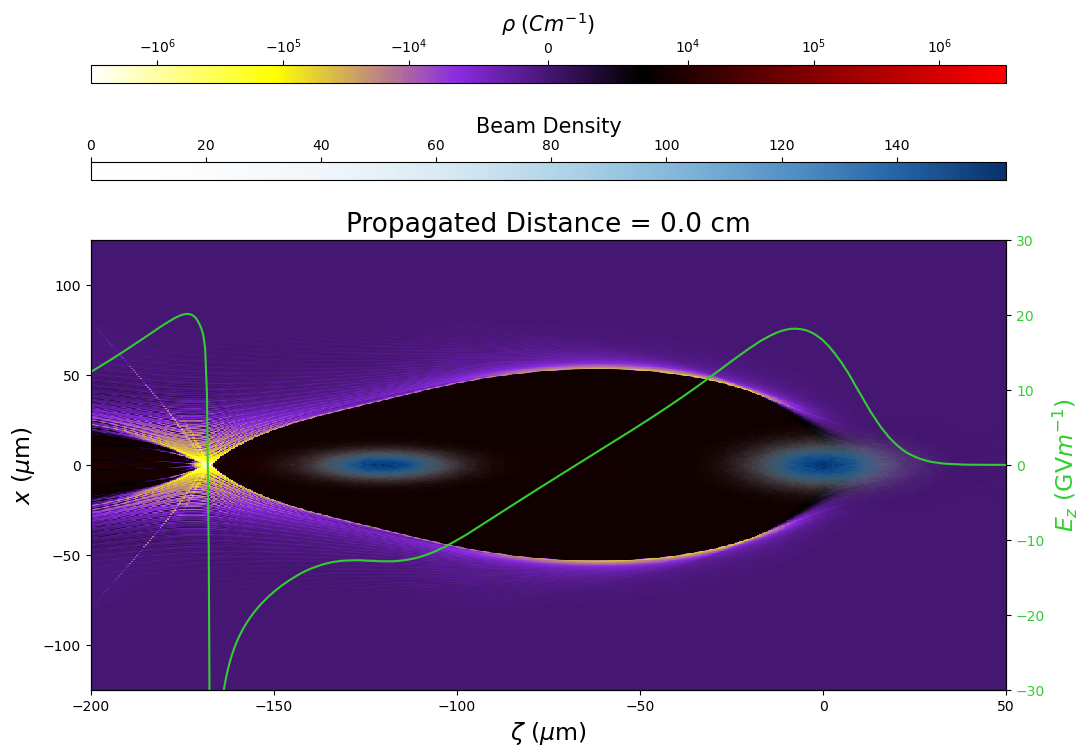

In [8]:
ts = OpenPMDTimeSeries('./diags3/hdf5/')
plot_charge_field_and_two_beams(iteration=0, BeamName1='witness', BeamName2='driver', cbinfo=[r'$\rho$ $(Cm^{-1})$', 'Beam Density'], vars=['x','y','z','w'], dens=5e22)

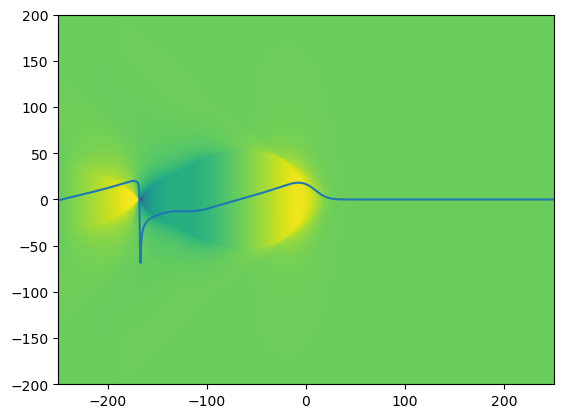

In [9]:
plot_field('Ez', iteration=0, lineout=True)

## Data Analysis

In [5]:
iteration = 30
rho, infor = ts.get_field(field='rho', iteration=iteration)
Ez, infoEz = ts.get_field(field='Ez', iteration=iteration)
ExmBy, infoEx = ts.get_field(field='ExmBy', iteration=iteration)

# get particle beams
xwit, ywit, uxwit, uywit, wwit, zwit = ts.get_particle(var_list=['x','y','ux','uy','w','z'], species='witness', iteration=iteration)
xdriv, ydriv, uxdriv, uydriv, wdriv, zdriv = ts.get_particle(var_list=['x','y','ux','uy','w','z'], species='driver', iteration=iteration)

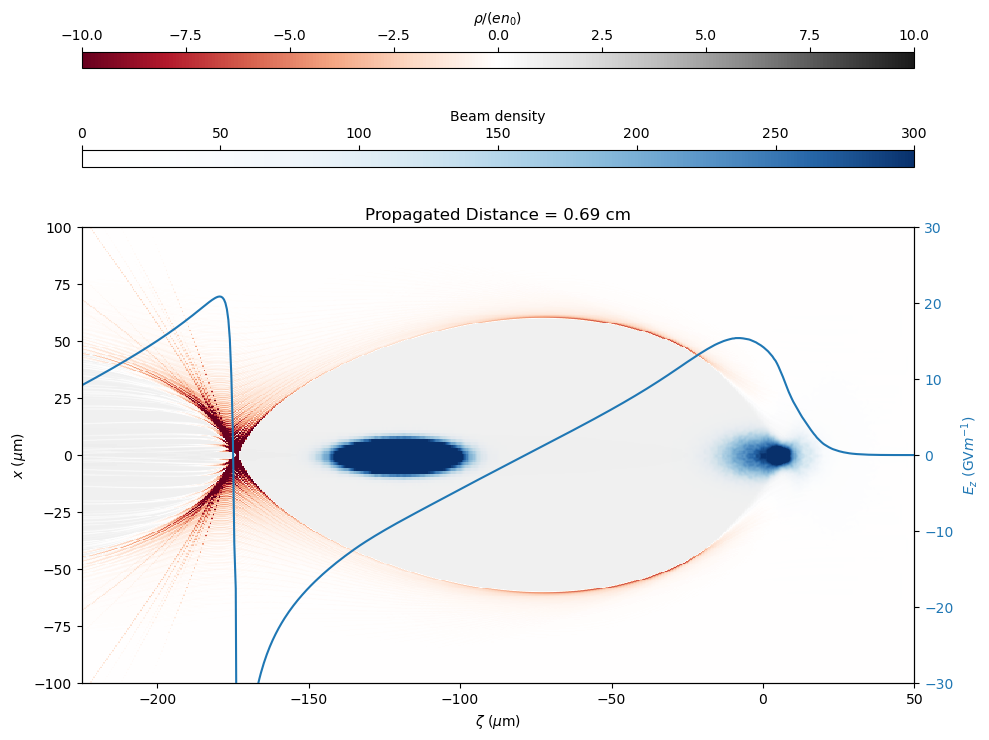

In [6]:
fig, ax1 = plt.subplots(figsize=(10,8))

# 2D plot for charge density
im = ax1.pcolormesh(infor.z*1e6, infor.x*1e6, (np.transpose(rho))/(scc.e*(3.5e22)), cmap='RdGy', vmin=-10, vmax=10)
cb1 = plt.colorbar(im, ax=ax1, location='top', aspect=50, pad=0.01)
cb1.set_label(r'$\rho / (e n_0)$')

norm = colors.SymLogNorm(linthresh=10000, vmin=-3.4e6, vmax=3.4e6)

# histogram for beam particles (both witness and drive beam)
Zwit, xedgeswit, yedgeswit = np.histogram2d(zwit[wwit>0]*1e6, xwit[wwit>0]*1e6, bins=[300,300])
Z2wit = ndimage.gaussian_filter(Zwit, sigma=1, order=0)
wit = ax1.pcolormesh(xedgeswit[0:len(xedgeswit)-1], yedgeswit[0:len(yedgeswit)-1], Z2wit.T, cmap=mycmap, vmin=0, vmax=300)
# ax.hist2d(zwit[wwit>0]*1e6, xwit[wwit>0]*1e6, bins=[200,200], cmap=mycmap, vmin=0, vmax=100) #---> witness beam
# ax.hist2d(zdriv[wdriv>0]*1e6, xdriv[wdriv>0]*1e6, bins=[200,200], cmap=mycmap, vmin=0, vmax=200) #---> drive beam

cb2 = plt.colorbar(wit, ax=ax1, location='top', aspect=50, pad=0.1)
cb2.set_label('Beam density')

Zdriv, xedgesdriv, yedgesdriv = np.histogram2d(zdriv[wdriv>0]*1e6, xdriv[wdriv>0]*1e6, bins=[300,300])
Z2driv = ndimage.gaussian_filter(Zdriv, sigma=1, order=0)
ax1.pcolormesh(xedgesdriv[0:len(xedgesdriv)-1], yedgesdriv[0:len(yedgesdriv)-1], Z2driv.T, cmap=mycmap, vmin=0, vmax=300)

newEz = np.transpose(Ez)[512]/1e9
# print(ts.t[iteration]-ts.t[iteration-1])
# print(round(iteration*3e-13*3e8*100, 2))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(r'$E_z$ (GV$m^{-1}$)', color=color)
# ax2.plot(np.linspace(-250,250,1024), newEz, color=color)
ax2.plot(infoEz.z*1e6, np.transpose(Ez)[512, :]*1e-9, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-30,30)

# labels and plot layout
ax1.set_ylabel(r'$x$ ($\mu$m)')
ax1.set_xlabel(r'$\zeta$ ($\mu$m)')
ax1.set_xlim(-225, +50)
ax1.set_ylim(-100, 100)
plt.title('Propagated Distance = ' + str(round(iteration*(ts.t[iteration]-ts.t[iteration-1])*3e8*100, 2))+ ' cm')
plt.tight_layout()

## GIF of Data

In [ ]:
for i in range(0,100):
    iteration = i
    rho, infor = ts.get_field(field='rho', iteration=iteration)
    Ez, infoEz = ts.get_field(field='Ez', iteration=iteration)
    ExmBy, infoEx = ts.get_field(field='ExmBy', iteration=iteration)

    # get particle beams
    xwit, ywit, uxwit, uywit, wwit, zwit = ts.get_particle(var_list=['x','y','ux','uy','w','z'], species='witness', iteration=iteration)
    xdriv, ydriv, uxdriv, uydriv, wdriv, zdriv = ts.get_particle(var_list=['x','y','ux','uy','w','z'], species='driver', iteration=iteration)

    fig, ax = plt.subplots(figsize=(6,3.5));

    # 2D plot for charge density
    im = ax.pcolormesh(infor.z*1e6, infor.x*1e6, (np.transpose(rho))/(scc.e*(1e21)), cmap='RdGy', vmin=-30, vmax=30);
    cb = plt.colorbar(im, ax=ax);
    cb.set_label(r'$\rho / (e n_0)$')

    # histogram for beam particles (both witness and drive beam)
    Zwit, xedgeswit, yedgeswit = np.histogram2d(zwit[wwit>0]*1e6, xwit[wwit>0]*1e6, bins=[400,400])
    Z2wit = ndimage.gaussian_filter(Zwit, sigma=1, order=0)
    wit = ax.pcolormesh(xedgeswit[0:len(xedgeswit)-1], yedgeswit[0:len(yedgeswit)-1], Z2wit.T, cmap=mycmap, vmin=0, vmax=400)
    # ax.hist2d(zwit[wwit>0]*1e6, xwit[wwit>0]*1e6, bins=[200,200], cmap=mycmap, vmin=0, vmax=100) #---> witness beam
    # ax.hist2d(zdriv[wdriv>0]*1e6, xdriv[wdriv>0]*1e6, bins=[200,200], cmap=mycmap, vmin=0, vmax=200) #---> drive beam
    plt.colorbar(wit, ax=ax)

    Zdriv, xedgesdriv, yedgesdriv = np.histogram2d(zdriv[wdriv>0]*1e6, xdriv[wdriv>0]*1e6, bins=[200,200])
    Z2driv = ndimage.gaussian_filter(Zdriv, sigma=1, order=0)
    ax.pcolormesh(xedgesdriv[0:len(xedgesdriv)-1], yedgesdriv[0:len(yedgesdriv)-1], Z2driv.T, cmap=mycmap, vmin=0, vmax=200)
    
    # labels and plot layout
    ax.set_ylabel(r'$x$ in $\mu$m');
    ax.set_xlabel(r'$\zeta$ in $\mu$m');
    ax.set_xlim(-225, +100);
    ax.set_ylim(-150, 150);
    plt.title('Propagated Distance = ');
    plt.tight_layout();

    
    plt.savefig("imgs4/"+str(i)+".png")

In [ ]:
import os
import imageio.v2 as imageio
images=[]
png_dir = 'imgs4'
for file_name in sorted(os.listdir(png_dir), key=lambda x: int(x.split(".")[0])):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

frames = []
for image in images:
    img = Image.fromarray(image)
    frames.append(img)

frames[0].save(
    "output.gif",
    format = "GIF",
    save_all = True,
    loop = 0,
    append_images = frames,
    duration = 100

)


In [ ]:
import sys
import pyvips

# load all the frames
frames = [pyvips.Image.new_from_file('imgs4', access="sequential")
          for filename in sys.argv[2:]]

# join into a tall, thin strip
roll = pyvips.Image.arrayjoin(frames, across=1)

# set the delay and page-height metadata
# you must make a private copy of the image before modifying it
roll = roll.copy()
roll.set_type(pyvips.GValue.array_int_type, "delay", [66] * len(frames))
roll.set_type(pyvips.GValue.gint_type, "page-height", frames[0].height)

roll.write_to_file(sys.argv[1])